## Import Libraries

In [2]:
#!pip3 install tensorflow keras matplotlib scikit-learn

#from google.colab import drive
import os
import shutil
import numpy as np
import random as rn
import tensorflow as tf
import matplotlib.cm as cm
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer

from keras.applications import VGG16
from keras.models import Sequential ,load_model
from keras.layers import Dense, Dropout, Flatten


2023-05-21 13:40:06.493455: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Google Drive connection

In [3]:
# mount drive 
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Utilities

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import os

from tensorflow.keras import backend as K
from itertools import cycle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score

# # su colab
# dataset_path = "/content/drive/MyDrive/BrainTumorDataset"

# # Percorso della cartella "unified" che contiene le sottocartelle delle classi
# base_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Unified"

# # Definisci i percorsi per il set di test, di validazione e di addestramento
# test_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Test"
# val_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Validation"
# train_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Train"

# per locale
dataset_path = "BrainTumorDataset"

# Percorso della cartella "unified" che contiene le sottocartelle delle classi
base_path = "BrainTumorDataset/Preprocessed/Unified"

# Definisci i percorsi per il set di test, di validazione e di addestramento
test_path = "BrainTumorDataset/Preprocessed/Test"
val_path = "BrainTumorDataset/Preprocessed/Validation"
train_path = "BrainTumorDataset/Preprocessed/Train"

models_path = "/content/drive/MyDrive/BrainTumorDataset/Models"
cnn_results_path = os.path.join(models_path, 'CNN')
vgg16_results_path = os.path.join(models_path, 'VGG16')
resnet50_results_path = os.path.join(models_path, 'ResNet50')
inceptionv3_results_path = os.path.join(models_path, 'InceptionV3')

#dict of labels
labels_dict= {0:'glioma_tumor', 1:'meningioma_tumor', 2:'no_tumor', 3:'pituitary_tumor'}

def set_seed ():
	''' 
	set_seed is used to obtain reproducible results using keras during the development phase
	'''
	seed = 10
	# The below is necessary for reproducible results of certain Python hash-based operations.
	os.environ["PYTHONHASHSEED"]="0"
	# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
	np.random.seed(seed)
	# The below is necessary for starting core Python generated random numbers in a well-defined state.
	rn.seed(seed)
	# The below tf.random.set_seed will make x number generation in TensorFlow have a well-defined initial state.
	tf.random.set_seed(seed)     

# Definisci le dimensioni delle immagini
image_size = 250
batch_size = 32

# Crea un oggetto ImageDataGenerator per il preprocessing delle immagini
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Carica le immagini dal set di addestramento
train_generator = data_generator.flow_from_directory(
    train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

# Carica le immagini dal set di test
test_generator = data_generator.flow_from_directory(
    test_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Carica le immagini dal set di validazione
val_generator = data_generator.flow_from_directory(
    val_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)
     

def show_training_and_validation_performance(history,path):
	'''
	show_training_and_validation_performance is used to plot the performances during the training phase
	:param history: object in which are recorded all the events
	'''
	acc = history.history['accuracy']
	val_acc = history.history['val_accuracy']
	loss = history.history['loss']
	val_loss = history.history['val_loss']

	epochs = range(len(acc))

	plt.plot(epochs, acc, 'bo', label='Training accuracy')
	plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
	plt.title('Training and validation accuracy')
	plt.legend()

	plt.figure()

	plt.plot(epochs, loss, 'bo', label='Training loss')
	plt.plot(epochs, val_loss, 'b', label='Validation loss')
	plt.title('Training and validation loss')
	plt.legend()

	plt.savefig(path)

	plt.show()

def compile_model (model, optimizer='adam', learning_rate = 0.001):
	'''
	compile_model is used to compile the current model
	:param model: model to compile
	:param optimizer: optimizer to be used
	:param learning_rate: learning rate parameter for the optimizer
	'''
	if optimizer == 'adam':
		model.compile(loss="categorical_crossentropy",
		optimizer=optimizers.Adam(learning_rate=learning_rate),
		metrics=["accuracy"])
	elif optimizer == 'rmsprop':
		model.compile(loss="categorical_crossentropy",
					optimizer = optimizers.RMSprop(learning_rate=learning_rate),
					metrics=['accuracy'])
	model.summary()

def run_model (model, type, model_name, epochs = 100, patience=5, monitor='val_loss'):
	'''
	run_model is used to run the current mode
	:param model: model to run
	:param model_name: name given to save the model
	:param type: type of model, CNN, VGG16, ResNet50, InceptionV3
	:param epochs: how many epochs to do
	:param patience: patience value for Early Stopping
	:param monitor: what to monitor for Early Stopping and Model Checkpoint
	'''
	# local save path for the models
	save_path = os.path.join(models_path, type + '/' + model_name + '.h5') 
	callbacks_list = [
					keras.callbacks.EarlyStopping(monitor=monitor, patience=patience),
					keras.callbacks.ModelCheckpoint(
						filepath = save_path,
						monitor=monitor,
						verbose=1,
						save_best_only=True)
					]
	history = model.fit(train_generator,
						epochs=epochs,
						validation_data=val_generator,
						callbacks=callbacks_list)
	# save on Drive only the best model
	show_training_and_validation_performance(history,os.path.join(models_path, type + '/' + model_name + '_validation.png'))

def plot_roc_curve(y_true, y_pred, n_classes, class_labels, model_name, type):

    # Converti le etichette di classe in formato binario
    lb = LabelBinarizer()
    y_true_binary = lb.fit_transform(y_true)

    # Calcola i tassi di FPR e TPR per ogni classe
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_true_binary[:, i], y_pred[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    plt.figure()
    colors = ['blue', 'red', 'green', 'orange']  # Colori per le diverse classi

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, label='ROC curve {0} ({1:0.2f}%)'.format(class_labels[i], roc_auc[i]*100))

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(models_path, type + '/' + model_name + '_ROC.png'))
    plt.show()

def evaluate_model (model, test_generator, model_name, type):
	'''
	evaluate_model is used to plot some statistics about the performance on the test set
	:param model: model to consider
	'''
	labels_d= ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

	# get predictions
	y_score = model.predict(test_generator)
	# convert predictions to classes
	y_pred = np.argmax(y_score, axis=-1)
	# get true classes
	y_true = test_generator.classes
	# extract class labels
	class_labels = list(test_generator.class_indices.keys())
	
	print("Classification report: ")
	# create and show classification report
	print(metrics.classification_report(y_true, y_pred, target_names=class_labels,digits = 4))
	# save classification report
	with open(os.path.join(models_path, type + '/' + model_name + '_classification_report.txt'), 'w') as f:
		f.write(metrics.classification_report(y_true, y_pred, target_names=class_labels,digits = 4))

	# create and show confusion matrix	
	cm = confusion_matrix(y_true, y_pred)	
	disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
	disp.plot(xticks_rotation=45)
	
	# save confusion matrix
	plt.savefig(os.path.join(models_path, type, model_name + '_confusion_matrix.png'), bbox_inches='tight', pad_inches=0.1)
	plt.show()

	plot_roc_curve(y_true, y_score, 4, class_labels, model_name, type)

def display_feature_map(layer_names,activations):
	# Now let's display our feature maps
	for layer_name, layer_activation in zip(layer_names, activations):
			# This is the number of features in the feature map
			n_features = layer_activation.shape[-1]

			# The feature map has shape (1, size, size, n_features)
			size = layer_activation.shape[1]

			# We will tile the activation channels in this matrix
			n_cols = n_features // images_per_row
			display_grid = np.zeros((size * n_cols, images_per_row * size))

			# We'll tile each filter into this big horizontal grid
			for col in range(n_cols):
					for row in range(images_per_row):
							channel_image = layer_activation[0,:, :, col * images_per_row + row]
							# Post-process the feature to make it visually palatable
							channel_image -= channel_image.mean()
							channel_image /= channel_image.std()
							channel_image *= 64
							channel_image += 128
							channel_image = np.clip(channel_image, 0, 255).astype('uint8')
							display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

			# Display the grid
			scale = 1. / size
			plt.figure(figsize=(scale * display_grid.shape[1],
													scale * display_grid.shape[0]))
			plt.title(layer_name)
			plt.grid(False)
			plt.imshow(display_grid, aspect='auto', cmap='gray')
			
	plt.show()

def get_img(img_path, target_size=(224,224)):
    img = image.load_img(img_path, target_size=target_size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def get_img_for_pred(img_path, target_size=(224,224)):
	img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
	img_tensor = tf.keras.preprocessing.image.img_to_array(img)  # (height, width, channels)
	img_tensor = np.expand_dims(img_tensor, axis=0) 
	img_tensor /= 255.
	return img_tensor

def decode_predictions(pred):
	class_indices = np.argsort(pred)[0, ::-1][:4]  # Ottieni gli indici delle probabilità ordinate in modo decrescente per le prime 4 classi
	class_probabilities = pred[0, class_indices]  # Probabilità corrispondenti alle classi selezionate
	class_labels = [labels_dict[i] for i in class_indices]  # Etichette corrispondenti alle classi selezionate

	for label, probability in zip(class_labels, class_probabilities):
		print(f"{label}: {probability*100:.2f}%")

def get_last_conv_layer(model):
	conv_layer_names = []
	last_conv_layer = None
	for layer in model.layers[::-1]:
		if isinstance(layer, keras.layers.Conv2D):
			last_conv_layer = layer
			break
		else:
			conv_layer_names.append(layer.name)
	conv_layer_names = conv_layer_names[::-1]
	return last_conv_layer, conv_layer_names

def GradCAM_process(model, img_path, target_size=(224,224)):
	#import image and make prediction on the given model
	img_tensor = get_img_for_pred(img_path, target_size=target_size)
	preds = model.predict(img_tensor)
	decode_predictions(preds)

	#get last conv layer and list of dense part 
	last_conv_layer, classifier_layer_names = get_last_conv_layer(model)
	#create a model that map input to the last conv layer
	last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)
	classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
	
	x = classifier_input
	for layer_name in classifier_layer_names:
		x = model.get_layer(layer_name)(x)
	classifier_model = keras.Model(classifier_input, x)
	#classifier_model is composed by last conv layer + le dense part of the network

	return img_tensor, last_conv_layer_model, classifier_model

def create_heatmap(img_tensor,last_conv_layer_model,classifier_model):
	#compute gradient for input image respect to the activations of the last convolution layer
	with tf.GradientTape() as tape:
		last_conv_layer_output = last_conv_layer_model(img_tensor) # output feature maps of the last conv layer.
		tape.watch(last_conv_layer_output)
		preds = classifier_model(last_conv_layer_output)  
		top_pred_index = tf.argmax(preds[0])  #  meningioma_tumor prediction index
		top_class_channel = preds[:, top_pred_index] # meningioma_tumor prediction value
	#Gradient of the meningioma_tumor class with related to the output feature maps of last conv layer
	grads = tape.gradient(top_class_channel, last_conv_layer_output) 
	#Apply pooling and importance weighting to the gradient tensor to obtain heatmap of class activation
	pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy() # evaluate the mean over the gradient tensor, for each channel separately
	
	weighted_last_conv_layer_output = last_conv_layer_output.numpy()[0]
	for i in range(pooled_grads.shape[-1]):
		weighted_last_conv_layer_output[:, :, i] *= pooled_grads[i]

	heatmap = np.mean(weighted_last_conv_layer_output, axis=-1)
	heatmap = np.maximum(heatmap, 0)
	heatmap /= np.max(heatmap)

	return heatmap

def superimposed_img(img_path, heatmaps, save_path):
	models = ['CNN', 'VGG16', 'ResNet50', 'InceptionV3']
	img = keras.utils.load_img(img_path)
	img = keras.utils.img_to_array(img)

	fig, axes = plt.subplots(2, 2, figsize=(12, 10))
	fig.suptitle('Superimposed Images', fontsize=16)

	for i, ax in enumerate(axes.flat):
		heatmap = heatmaps[i]
		heatmap = np.uint8(255 * heatmap)

		jet = cm.get_cmap("jet")
		jet_colors = jet(np.arange(256))[:, :3]
		jet_heatmap = jet_colors[heatmap]

		jet_heatmap = keras.utils.array_to_img(jet_heatmap)
		jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
		jet_heatmap = keras.utils.img_to_array(jet_heatmap)

		superimposed_img = jet_heatmap * 0.8 + img
		superimposed_img = keras.utils.array_to_img(superimposed_img)

		ax.imshow(superimposed_img)
		ax.set_title(models[i])
		ax.axis('off')

	plt.tight_layout()
	plt.savefig(save_path)
	plt.show()

def plot_heatmaps(heatmaps):
    models = ['CNN', 'VGG16', 'ResNet50', 'InceptionV3']

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Models Heatmap', fontsize=16)

    for i, ax in enumerate(axes.flat):
        ax.imshow(heatmaps[i])
        ax.set_title(models[i])
        ax.axis('off')

    plt.tight_layout()
    plt.show()

def clear(model):
	del model
	K.clear_session() 

set_seed ()

Found 4488 images belonging to 4 classes.
Found 646 images belonging to 4 classes.
Found 646 images belonging to 4 classes.


# Sample Image

(1, 224, 224, 3)


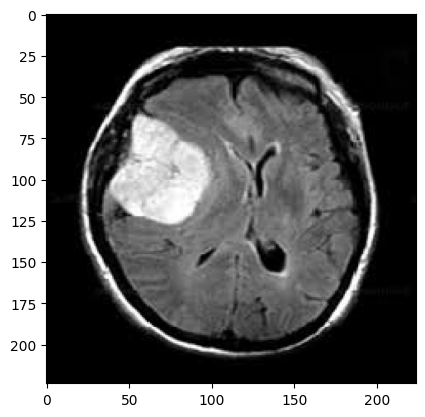

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 250, 250, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 125, 125, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 41, 41, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 10, 10, 128)     

In [7]:
model_path = os.path.join(dataset_path,"Models/cnn_from_scratch_exp8/cnn_from_scratch_exp8.h5")
model = load_model(model_path)
# get a random image from test set
img_path = os.path.join(test_path,"meningioma_tumor/meningioma_tumor_307.jpg")
# load the image
img_array = get_img(img_path, target_size=(image_size, image_size))
print(img_array.shape)

# display it
plt.imshow(img_array[0].astype('uint8'))
plt.show()
model.summary()

# Visualize Conv and Pooling activation

In [26]:
#get all conv and pooling layers
layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        print(layer.name)
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

# This will return a list of N Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_array)
print(len(activations))
for out in activations:
  print(out.shape)

conv2d_4
max_pooling2d_4
conv2d_5
max_pooling2d_5
conv2d_6
max_pooling2d_6
conv2d_7
max_pooling2d_7
1/1 [==============================] - 0s 226ms/step
8
(1, 250, 250, 32)
(1, 125, 125, 32)
(1, 125, 125, 64)
(1, 41, 41, 64)
(1, 41, 41, 128)
(1, 10, 10, 128)
(1, 10, 10, 256)
(1, 2, 2, 256)


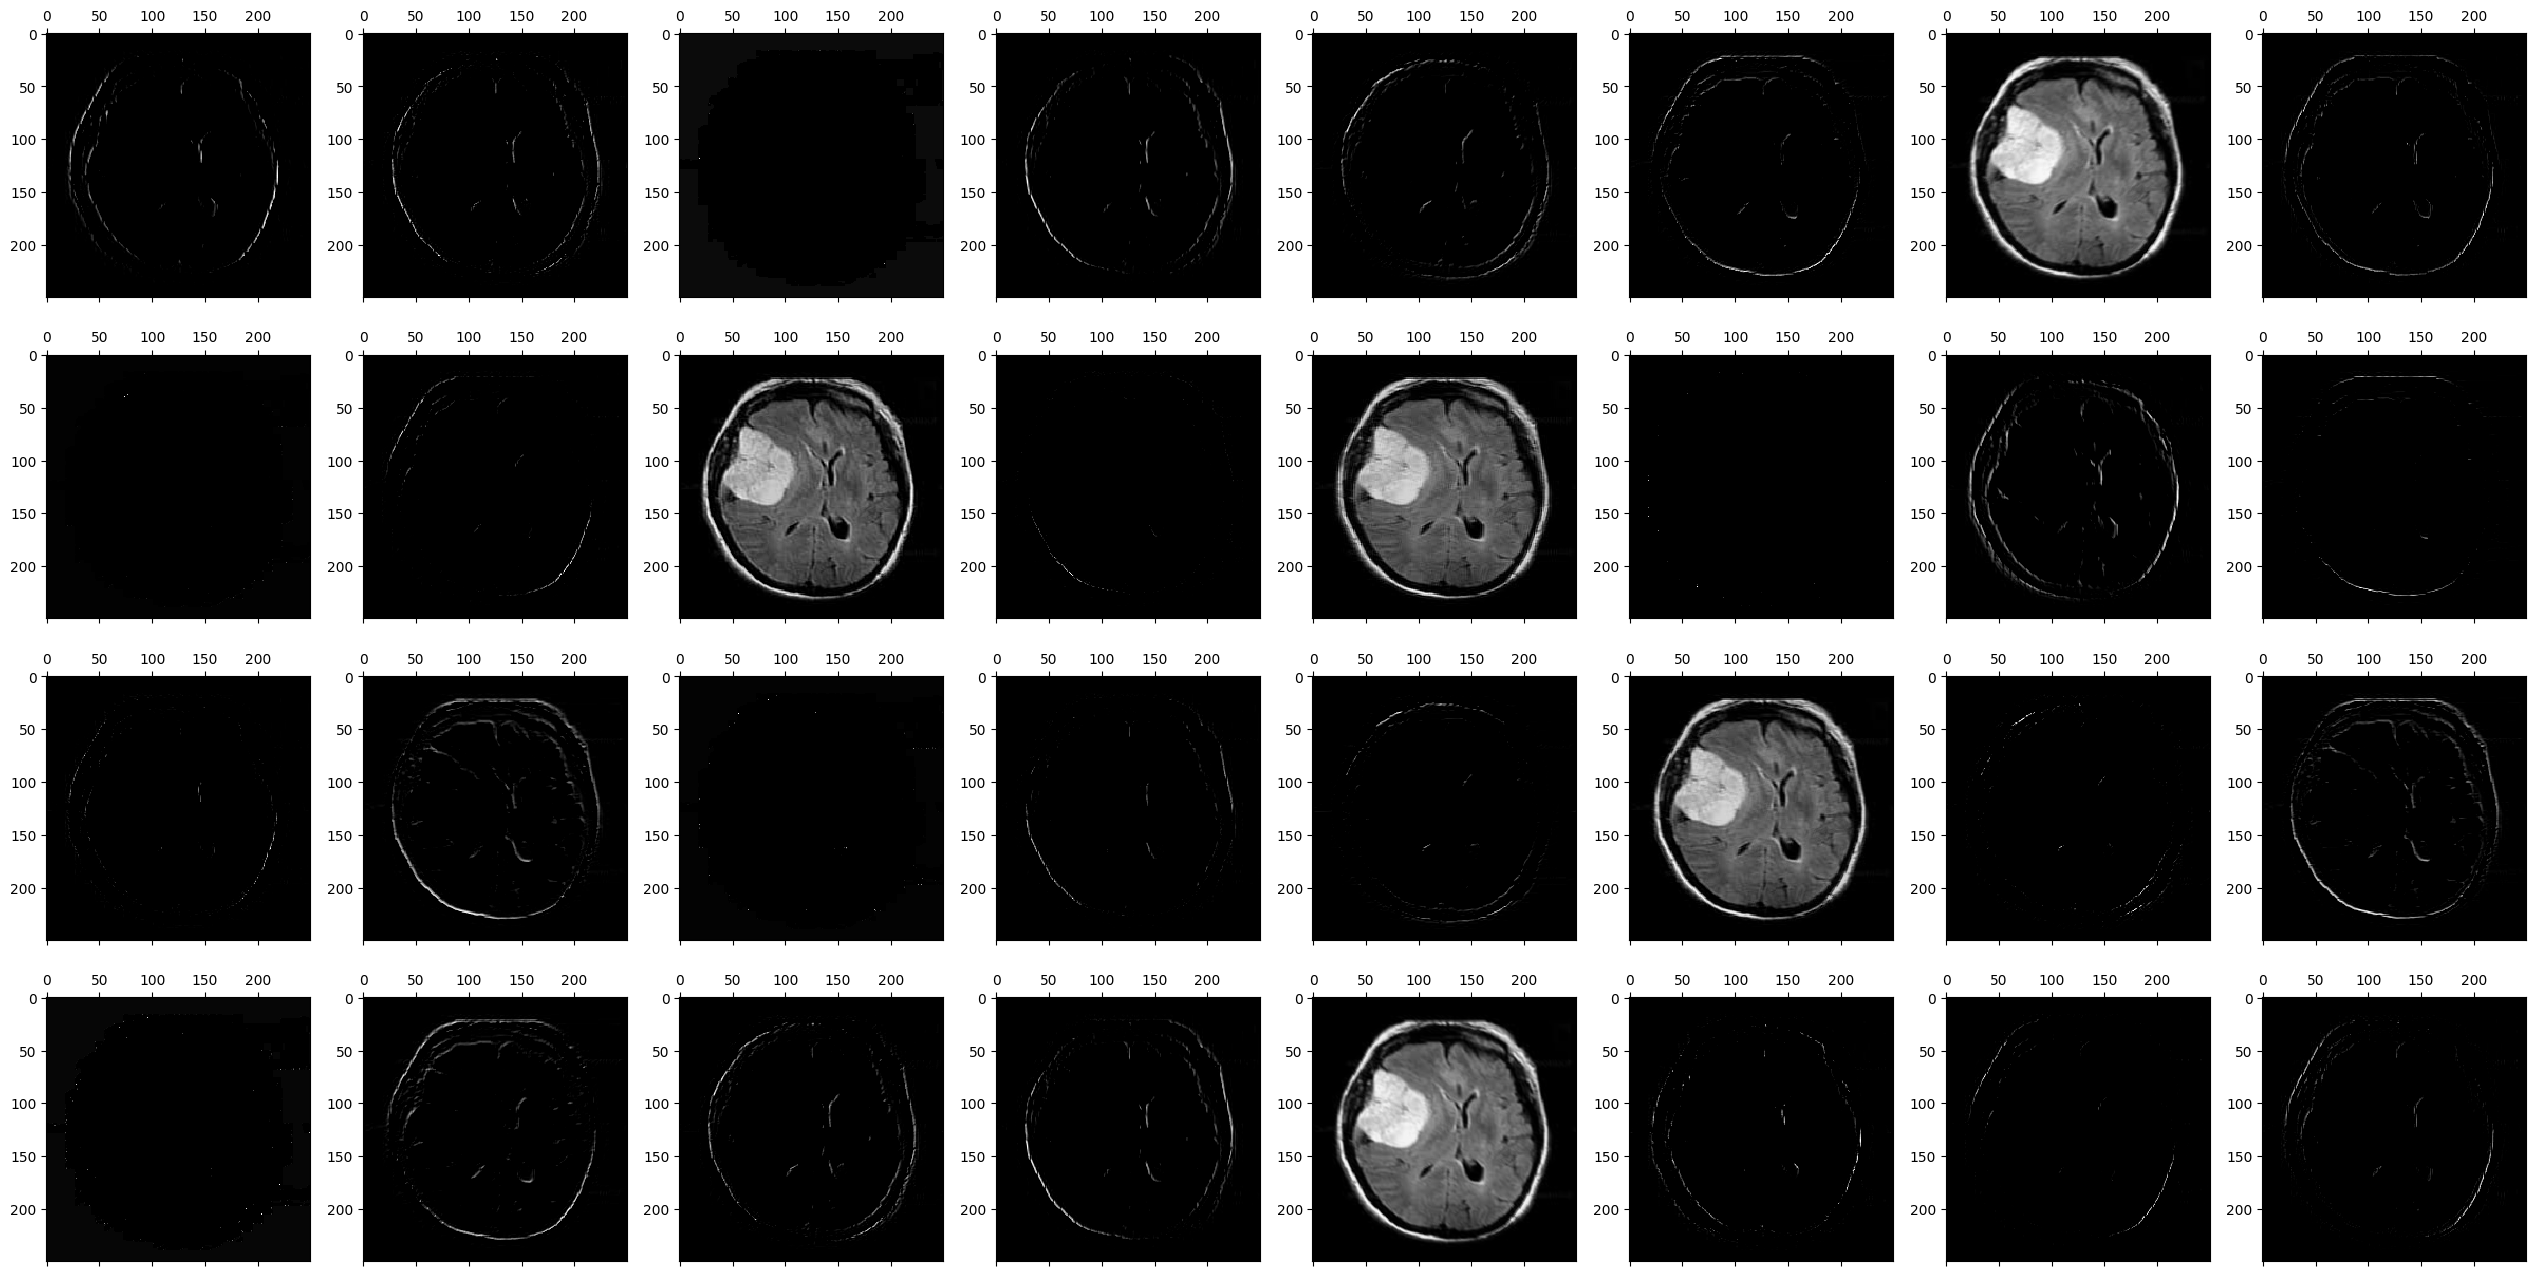

In [27]:
first_layer_activation = activations[0]

#visualize the activation of the first layer
fig, ax = plt.subplots(4, 8, figsize=(32, 16))
for k in range(8):
    ax[0, k].matshow(first_layer_activation[0, :, :, k], cmap='gray')
    ax[1, k].matshow(first_layer_activation[0, :, :, k+8], cmap='gray')
    ax[2, k].matshow(first_layer_activation[0, :, :, k+16], cmap='gray')
    ax[3, k].matshow(first_layer_activation[0, :, :, k+24], cmap='gray')
plt.show()

/var/folders/jq/sxfhvkbn11s0jzgvkdhwp6v00000gn/T/ipykernel_4256/2440775406.py:220: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()


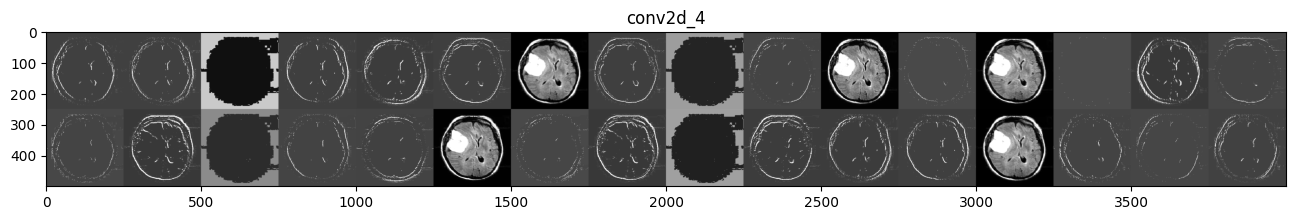

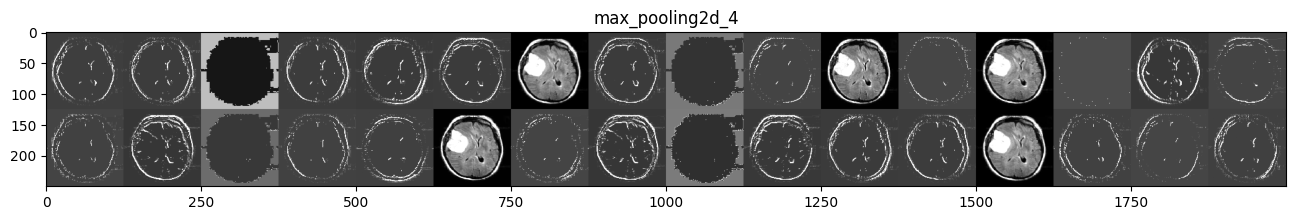

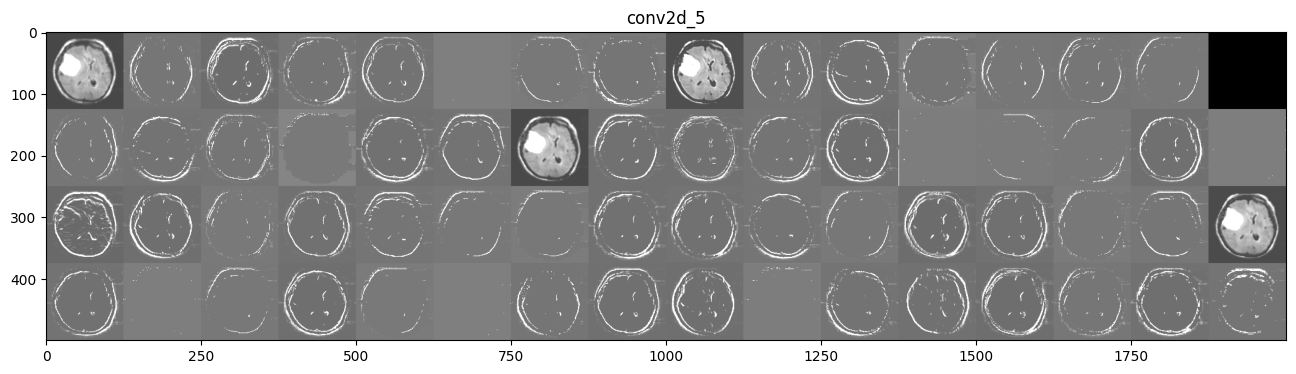

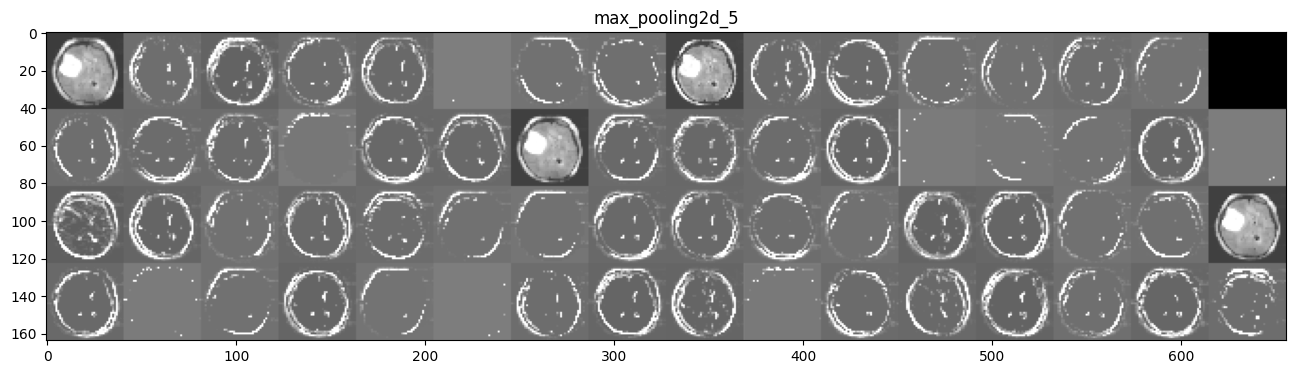

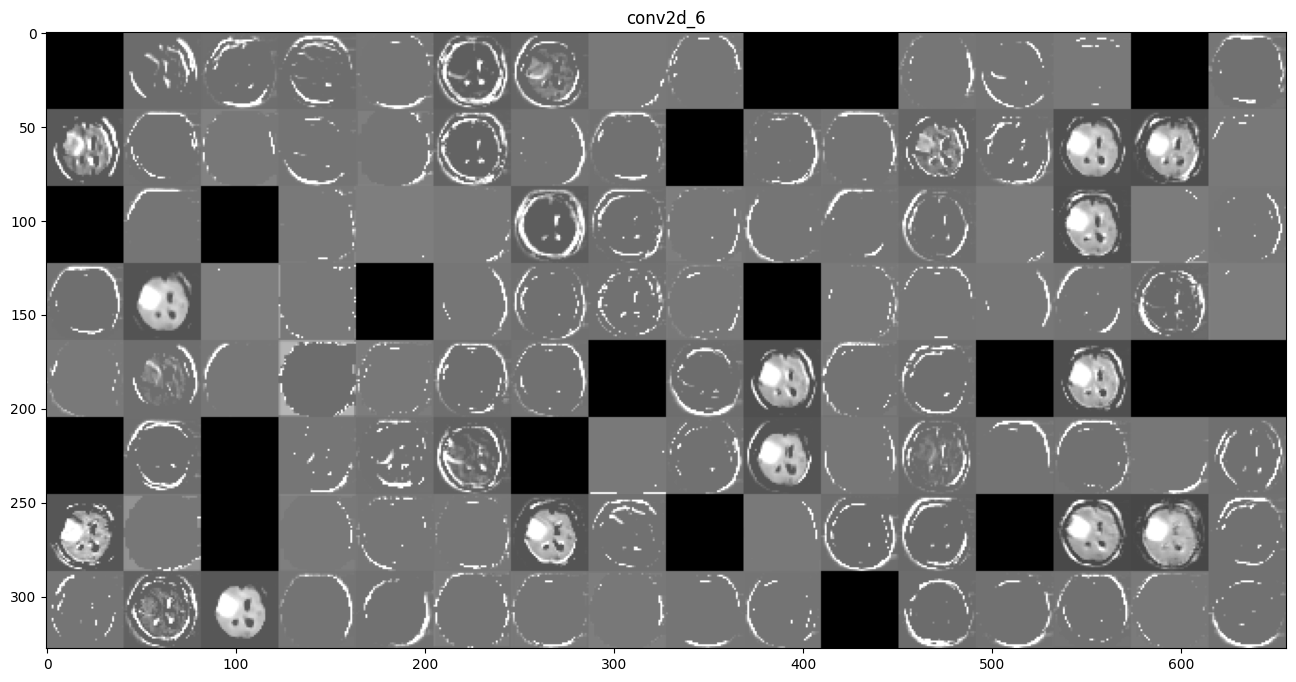

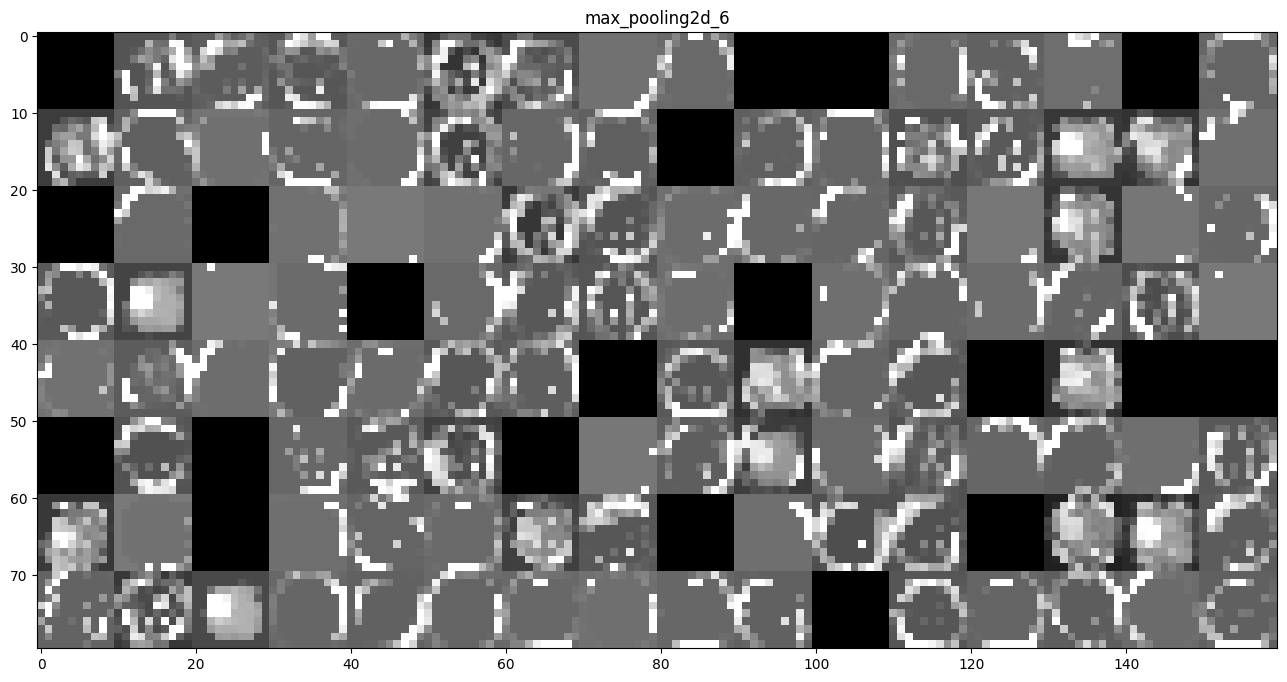

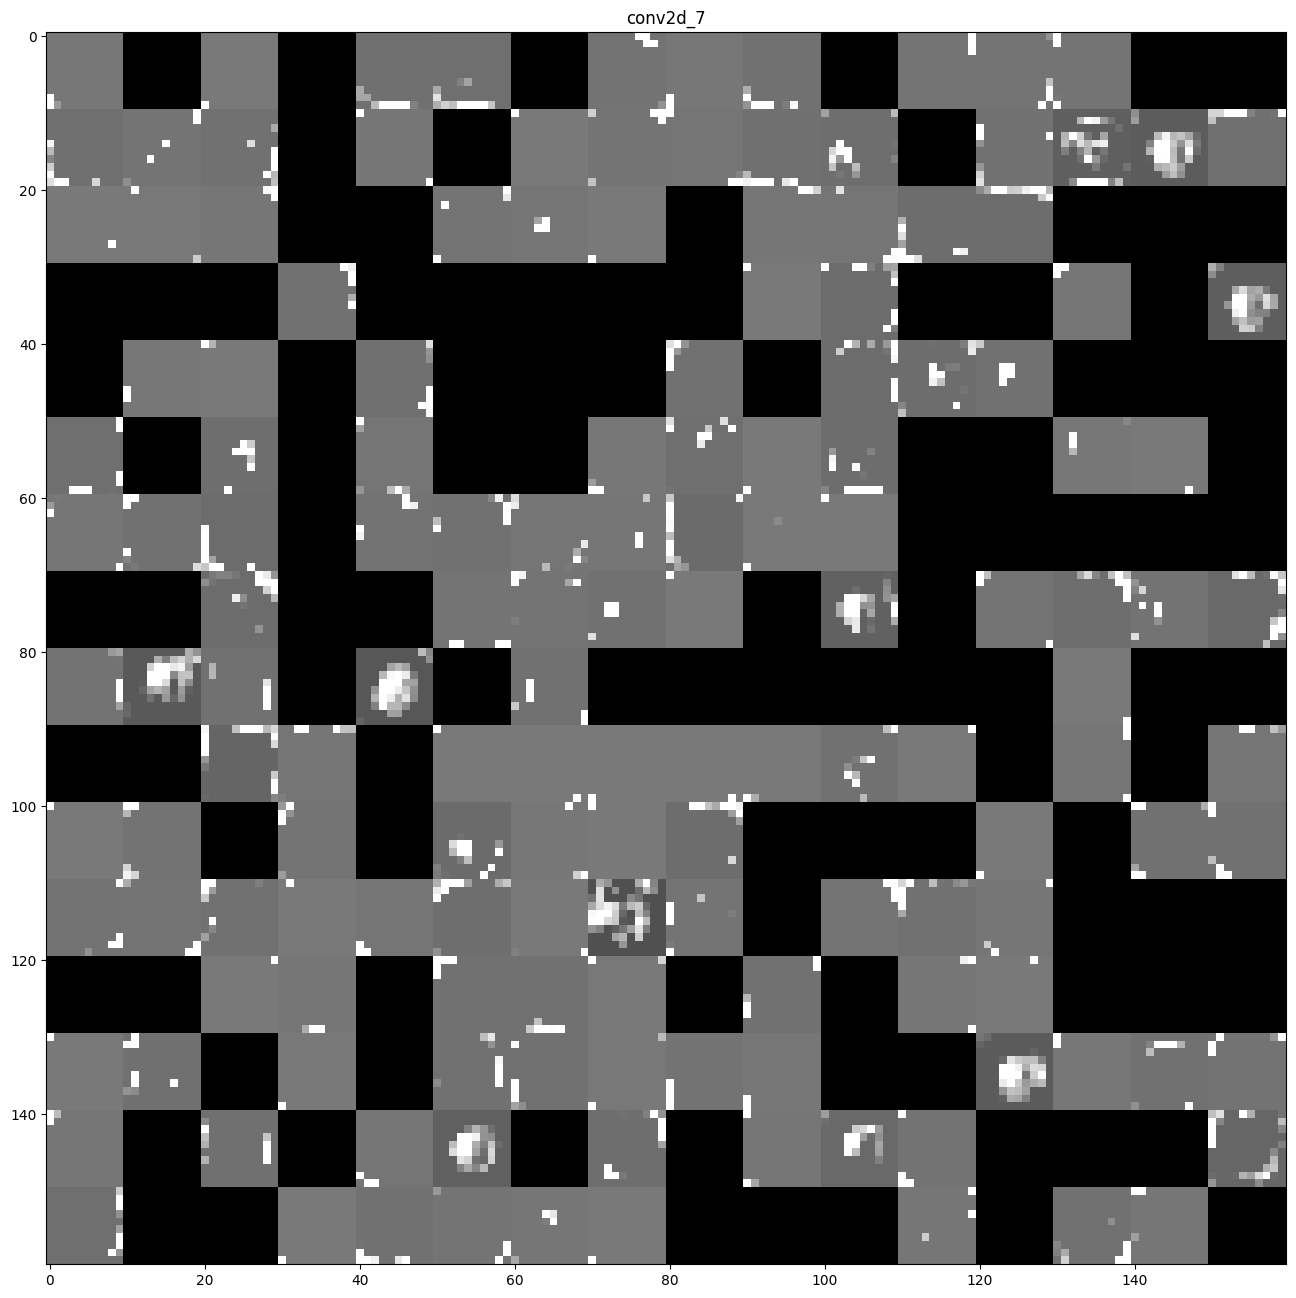

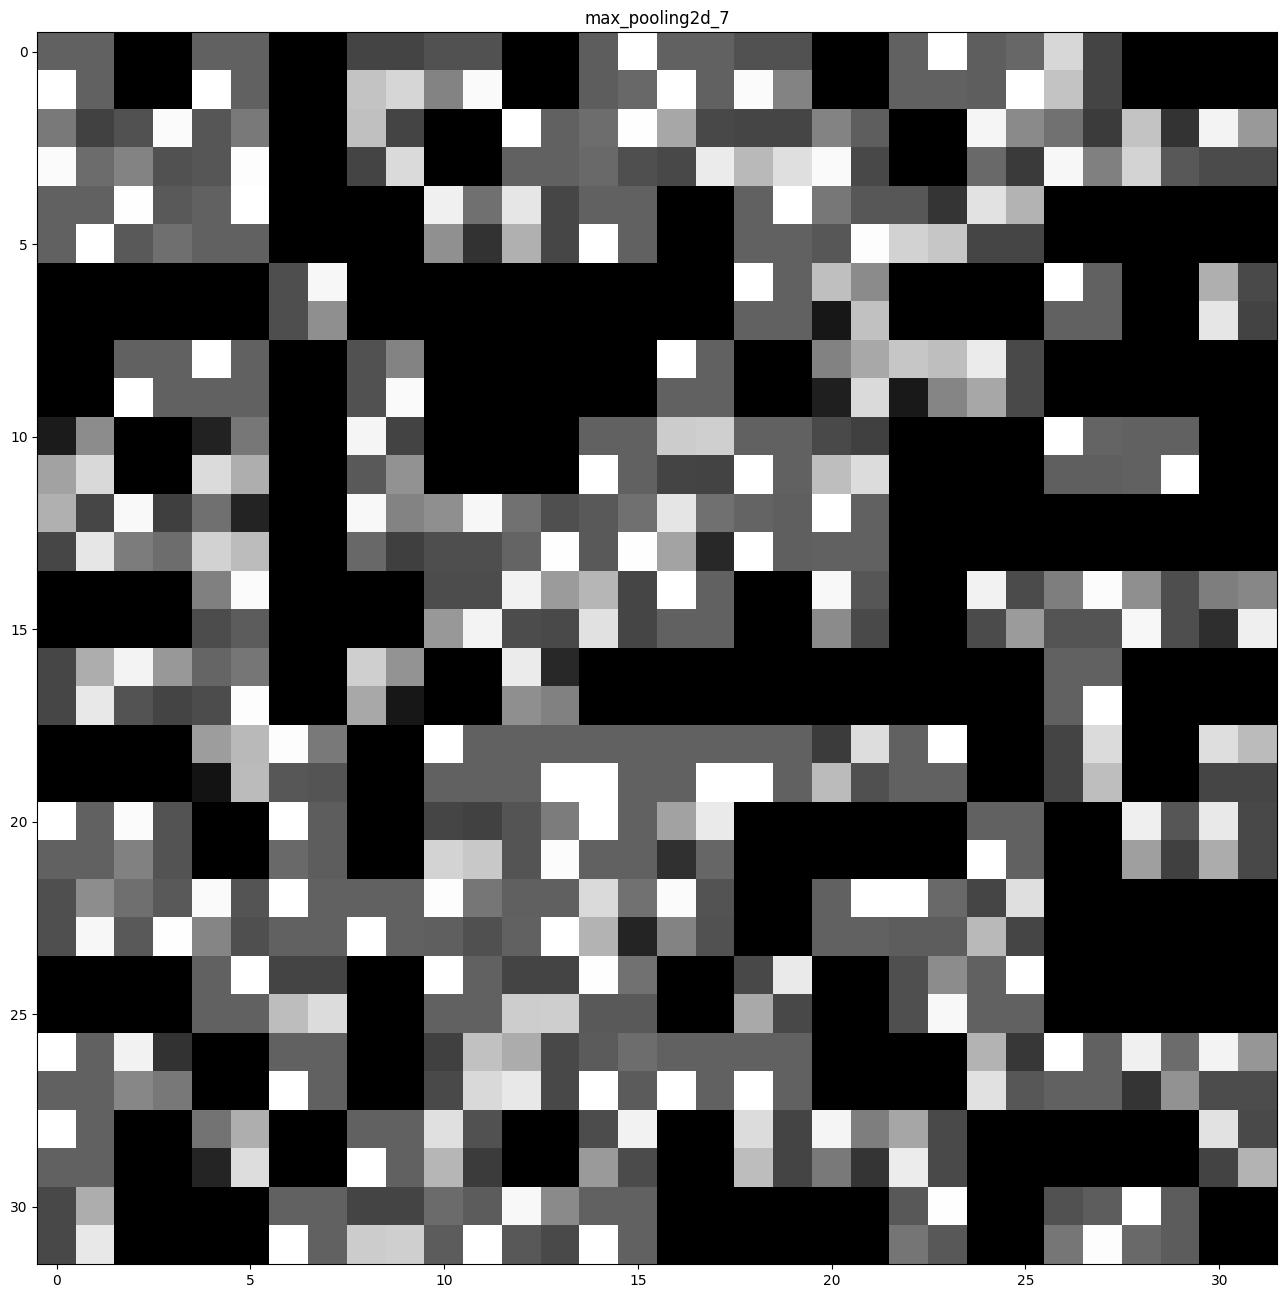

In [7]:
display_feature_map(layer_names,activations)

# Visualize Heatmap


In [25]:
img_tensor, last_conv_model, classifier_model = GradCAM_process(model,img_path,(image_size,image_size))

1/1 [==============================] - 0s 231ms/step
meningioma_tumor: 69.50%
no_tumor: 18.14%
glioma_tumor: 12.36%
pituitary_tumor: 0.00%


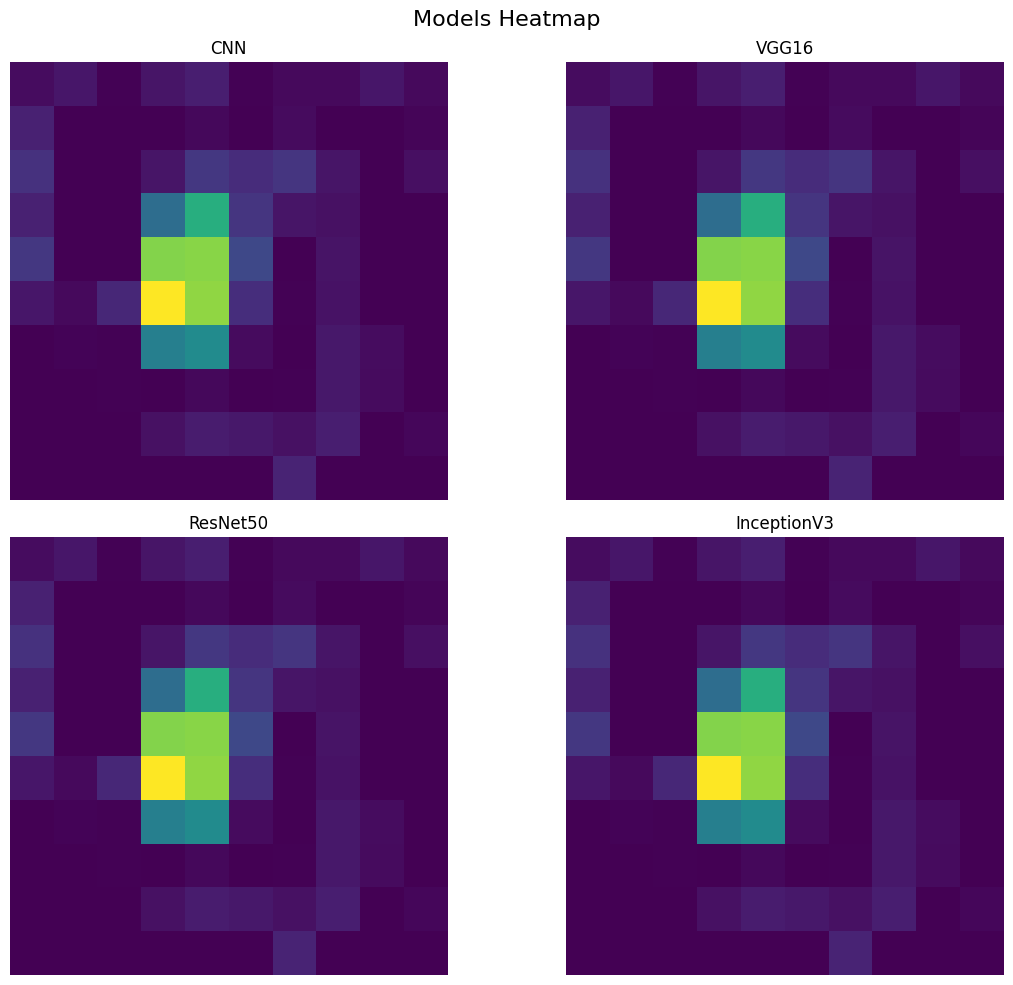

In [54]:
heatmap = create_heatmap(img_tensor,last_conv_model,classifier_model)
plot_heatmaps([heatmap,heatmap,heatmap,heatmap])

/var/folders/jq/sxfhvkbn11s0jzgvkdhwp6v00000gn/T/ipykernel_3411/3388473358.py:347: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


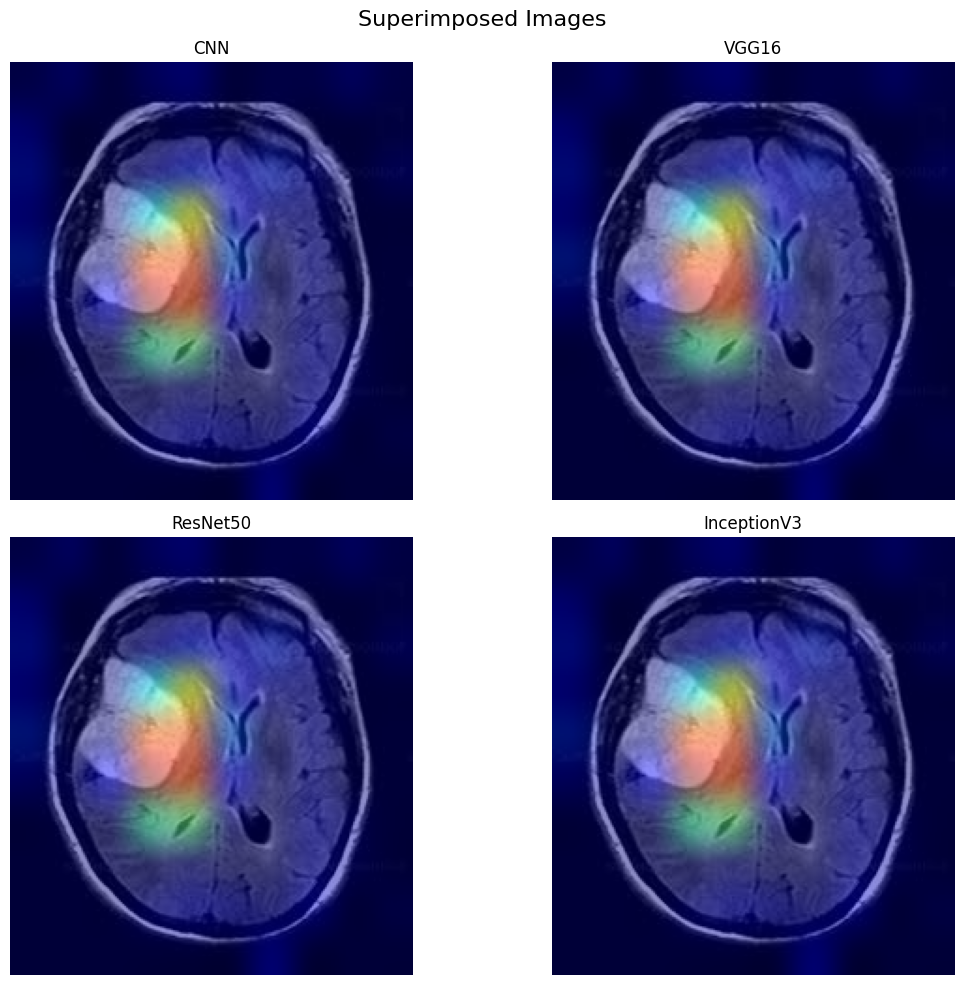

In [63]:
save_path = os.path.join(dataset_path,"Models/cnn_from_scratch_exp8/heatmap.jpg")
superimposed_img(img_path,[heatmap,heatmap,heatmap,heatmap],save_path)